## Preparation

#### Import libraries needed.

In [1]:
import pandas as pd
import re 
import xlrd # to read excel
import nltk # NLP toolkit
import matplotlib.pyplot as plt # for visualization
import string # for handling string
import seaborn as sns
import spacy

#### Access the location of origin file by declaring the path

In [2]:
# give the location 
data_path = '/Users/cathzzr2/Desktop/dataset/'
data_filename = 'dataset.xlsx'
# default path to the origin_file
summary = pd.read_excel(data_path + data_filename,header=0) # (default: 0)

#### 1.1 Basic Properties - size, head, tail, etc. 

In [3]:
print(summary.shape) # size of the excel: (row, colume)
print(summary.columns) # index of columns
print(summary.head(3)) # preview top 3 rows (default: 5)
print(summary.tail(3)) # preview top 3 rows (default: 5)
print(summary.describe) # only integer variables are shown
print(summary.nunique)
print(summary['Authors'].unique())

(1712, 8)
Index(['Title', 'Authors', 'Date', 'UID', 'Summary', 'PDF URL', 'Cyber_Risk',
       'Not_Cyber'],
      dtype='object')
                                               Title  \
0                   Cyber security and the Leviathan   
1  Evaluation of Machine Learning Algorithms in N...   
2  Getting Critical: Making Sense of the EU Cyber...   

                                 Authors       Date           UID  \
0                    ['Joseph Da Silva'] 2022-03-10  2203.05256v1   
1   ['Tuan-Hong Chua', 'Iftekhar Salam'] 2022-03-10  2203.05232v1   
2  ['Ian Walden', 'Johan David Michels'] 2022-03-09  2203.04887v1   

                                             Summary  \
0  Dedicated cyber-security functions are common ...   
1  Cybersecurity has become one of the focuses of...   
2  In this chapter, we review how the EU cybersec...   

                                 PDF URL  Cyber_Risk  Not_Cyber  
0  http://arxiv.org/pdf/2203.05256v1.pdf         1.0        0.0  
1  http://

#### 2.1 Cleaning the Data - remove null cells, convert to lowercases, remove punctuations

In [4]:
# number of null cells in each columns
print(summary.isnull().sum()) 
# drop unnecessary index and store it to a new file
new = summary.drop(['Date', 'UID', 'PDF URL', 'Cyber_Risk', 'Not_Cyber'], axis=1) 
# Lowercase the summary
new['summary_in_lowercase']=new['Summary'].apply(lambda x: x.lower())
new['summary_without_punkt']=new['summary_in_lowercase'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(new.head(1))

Title            0
Authors          0
Date             0
UID              0
Summary          0
PDF URL          0
Cyber_Risk    1709
Not_Cyber     1709
dtype: int64
                              Title              Authors  \
0  Cyber security and the Leviathan  ['Joseph Da Silva']   

                                             Summary  \
0  Dedicated cyber-security functions are common ...   

                                summary_in_lowercase  \
0  dedicated cyber-security functions are common ...   

                               summary_without_punkt  
0  dedicated cybersecurity functions are common i...  


#### 2.2 Cleaning the Data - download stopwords

In [5]:
from nltk.corpus import stopwords
stoplist = set(stopwords.words("english"))
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/cathzzr2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Exploratory Data Analysis

#### 3.1 Tokenization

In [ ]:
from nltk.tokenize import word_tokenize 

# tokenization
def preprocess(text):
  formatted_text = text.lower()
  tokens = []
  for token in nltk.word_tokenize(formatted_text):
    tokens.append(token)
  tokens = [word for word in tokens if word not in stoplist and word not in string.punctuation]
  formatted_text1 = ' '.join(element for element in tokens)
  formatted_text2 = ''.join([i for i in formatted_text1 if not i.isdigit()])
  return formatted_text2

# remove stop words
new['summary_without_stopw']=new['summary_without_punkt'].apply(lambda x: preprocess(x))

# remove numbers

new['summary_without_num']=new['summary_without_stopw'].apply(lambda x: x.replace(r'\d+',''))

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
new['lemmatized']=new['summary_without_num'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


#### 4.1 Word Frequency - Document Term Matrix

In [ ]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(new['lemmatized'])
new_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
new_dtm.index=new.index
new_dtm.head(10) # customize rows

#### 4.2.1 Word Frequency - Visualization - Word Cloud 

AttributeError: 'int' object has no attribute 'expandtabs'

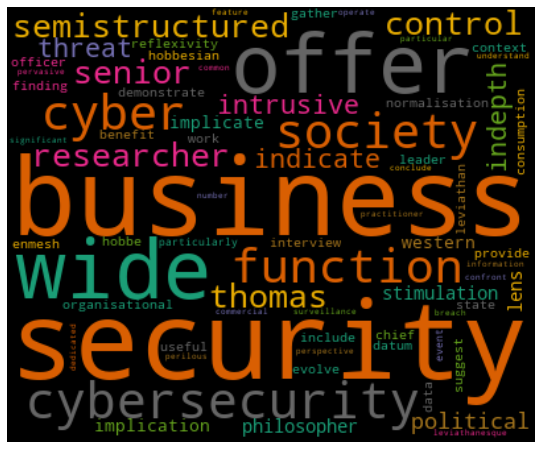

In [16]:
from wordcloud import WordCloud
from textwrap import wrap
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
new_dtm=new_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(new_dtm.columns):
  generate_wordcloud(new_dtm[product].sort_values(ascending=False),product)

#### 4.2.2 Word Frequency - Visualization - Plot with MATLAB